# Atividade Aprendizagem de Máquina - Spark MLLib

Considerando o dataset detalhado a seguir, aplique as técnicas solicitadas

### Dataset dados de sensores veicular

- Arquivo disponível em /home/dados/sensores/treinamento.csv
- Arquivo disponível em /home/dados/sensores/teste.csv
- Dados relativos a sensores de internet das coisas (IoT) para detecção de estados dos medidores


| #  	| Nome do campo           	| Descrição                                                                     	|
|----	|-------------------------	|-------------------------------------------------------------------------------	|
| 0  	| Hora               	| Hora média das medições                                                          	|
| 1  	| Minuto         	| Minuto médio das medições                                               	|
| 2  	| Temp_minima         	| Temperatura mínima das medições                                               	|
| 3  	| Temp_maxima         	| Temperatura máxima das medições                                               	|
| 4  	| Latitude_media  	| Latitude média das medições                             	|
| 5  	| Longitude_media  	| Longitude média das medições                             	|
| 6  	| Classe  	| Estado do medidor (Frio, Moderado, Quente, Alerta)                             	|


**Informações a serem extraídas:**

1. Calcule a acurácia de classificação na base de testes para os seguintes classificadores:
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
2. Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente como outra classe (falso-negativo) para os classificadores
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
3. Determine qual a quantidade de eventos não Alerta (label = 0.0, ou label = 1.0, ou label = 2.0) classificados erroneamente como classe Alerta (falso-positivo) para os classificadores
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 5 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=5 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
4. Faça votação entre os classificadores da etapa 1.A, 1.B e 1.C para atribuir a classe do evento de acordo com a maioria das classes entre os classificadores
    - Dicas: Para isto, voce irá precisar fazer o join das predições de cada classificador de acordo com os IDs dos eventos. Posteriormente voce pode manipular o dataframe, após o join, para determinar qual classe de cada evento possuiu maior votação =). Exemplo de código:
```python

    import pyspark.sql.functions as func
    
    predicaoDT.select(func.col('prediction').alias('prediction_dt'),
                        func.col('label'),
                        func.col('id'))\
    .join(predicaoRF.select(func.col('prediction').alias('prediction_rf'),
                        func.col('id')), ['id'])
```
5. Considerando que voce possui apenas duas classes: Não Alerta e Alerta. Calcule a acurácia de classificação na base de testes para os seguintes classificadores:
    1. Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    2. Random Forest com 20 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=20 no construtor do RandomForestClassifier)
    3. Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
        - Dicas: Para isto, você irá precisar manipular o dataframe para alterar os valores da coluna label, por exemplo através de uma UDF
6. Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente como outra classe (falso-negativo) para os classificadores do item 5
7. Faça busca de parametros dos classificadores desenvolvidos no item 5. Plote um gráfico relacionando a acurácia e os parametros otimizados
    1. Árvore de Decisão varie o parametro maxDepth de 1 a 20
    2. Random Forest varie o numTrees de 1 a 20

**Dicas:**
- *Crie uma célula (Insert -> Insert Cell Below) para cada informação solicitada*
- *A análise deve ser feita sobre os dados do HDFS*
- *Inicialize o seu cluster executando o script em: Desktop/ambientes/spark/inicializar.sh*
- *Acesse o seu cluster executando o script em: Desktop/ambientes/spark/abrir_navegador.sh*

In [ ]:
import os
os.environ['PYSPARK_PYTHON']='/usr/bin/python3'

from pyspark.sql import SparkSession

sc = SparkSession\
    .builder\
    .master('spark://spark-master:7077')\
    .config('spark.executor.memory','1g')\
    .getOrCreate()

In [ ]:
dfTreino = sc.read\
    .option('delimiter',',')\
    .option('header','true')\
    .option('inferschema','true')\
    .csv('hdfs://namenode:9000/treinamento.csv')

dfTeste = sc.read\
    .option('delimiter',',')\
    .option('header','true')\
    .option('inferschema','true')\
    .csv('hdfs://namenode:9000/teste.csv')

In [ ]:
dfTreino.printSchema()

root
 |-- hora: double (nullable = true)
 |-- minuto: double (nullable = true)
 |-- temp_minima: double (nullable = true)
 |-- temp_maxima: double (nullable = true)
 |-- latitude_media: double (nullable = true)
 |-- longitude_media: double (nullable = true)
 |-- Classe: string (nullable = true)



In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

dfTeste = dfTeste.withColumn('id', monotonically_increasing_id())
dfTeste.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+---+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe| id|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Moderado|  0|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Moderado|  1|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Moderado|  2|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Moderado|  3|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Moderado|  4|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

features = ['hora', 'minuto', 'temp_minima', 'temp_maxima', 'latitude_media', 'longitude_media']

#cria y
dfTreino = StringIndexer(inputCol='Classe', outputCol='label')\
    .fit(dfTreino)\
    .transform(dfTreino)

#cria x
dfTreino = VectorAssembler(inputCols=features, outputCol='features')\
    .transform(dfTreino)

dfTreino.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+--------+-----+--------------------+
|11.312758|30.169239|     -1.859|     27.495|     36.169994|      139.23022|Moderado|  0.0|[11.312758,30.169...|
|11.292323|29.638779|   8.542997|  36.177994|     31.349113|       73.50964|  Quente|  3.0|[11.292323,29.638...|
|11.600304| 29.64275|     -1.861|  27.695002|      36.17158|      139.22937|Moderado|  0.0|[11.600304,29.642...|
|11.462425|30.157314|   9.776998|  36.077995|     31.351593|        73.5104|  Quente|  3.0|[11.462425,30.157...|
|11.735474|  29.9684|     -1.662|  27.695002|     36.169456|      139.23021|Moderado|  0.0|[11.735474,29.968...|
+---------+---------+-----------+-----------+--------------+---------------+--------+-----+-----

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

features = ['hora', 'minuto', 'temp_minima', 'temp_maxima', 'latitude_media', 'longitude_media']

dfTeste = StringIndexer(inputCol='Classe', outputCol='label')\
    .fit(dfTeste)\
    .transform(dfTeste)

dfTeste = VectorAssembler(inputCols=features, outputCol='features')\
    .transform(dfTeste)

In [ ]:
#informação 1.A
from pyspark.ml.classification import DecisionTreeClassifier
import pyspark.sql.functions as func

dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')
modeloDT = dt.fit(dfTreino)

In [ ]:
predicaoDT = modeloDT.transform(dfTeste)
predicaoDT.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoDT)

0.9423485763266133

In [ ]:
#informação 1.B
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=5)
modeloRF = rf.fit(dfTreino)

In [ ]:
predicaoRF = modeloRF.transform(dfTeste)
predicaoRF.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [ ]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF)

0.9445431470178889

In [ ]:
#informação 1.C

rfCem = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
modeloRFCEM = rfCem.fit(dfTreino)
predicaoRFCEM = modeloRFCEM.transform(dfTeste)
predicaoRFCEM.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [ ]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRFCEM)

0.9465988646149552

In [ ]:
# Determine qual a quantidade de eventos Alerta (label = 1.0) 
# classificados erroneamente como outra classe (falso-negativo) para os classificadores

In [ ]:
predicaoDT.select(func.col('label'), func.col('Classe')).distinct().show(5)

+-----+--------+
|label|  Classe|
+-----+--------+
|  3.0|  Quente|
|  2.0|    Frio|
|  0.0|Moderado|
|  1.0|  Alerta|
+-----+--------+



In [ ]:
#informação 2.A
predicaoDT.printSchema()


root
 |-- hora: double (nullable = true)
 |-- minuto: double (nullable = true)
 |-- temp_minima: double (nullable = true)
 |-- temp_maxima: double (nullable = true)
 |-- latitude_media: double (nullable = true)
 |-- longitude_media: double (nullable = true)
 |-- Classe: string (nullable = true)
 |-- id: long (nullable = false)
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [ ]:
predicaoDT.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction')!= func.col('label'))\
    .count() / predicaoDT.filter(func.col('Classe') == 'Alerta').count()

0.049216759715973765

In [ ]:
#informação 2.B

predicaoRF.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction')!= func.col('label'))\
    .count() / predicaoRF.filter(func.col('Classe') == 'Alerta').count()

0.018158165754241423

In [ ]:
#informação 2.C


predicaoRFCEM.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction')!= func.col('label'))\
    .count() / predicaoDT.filter(func.col('Classe') == 'Alerta').count()

0.028619437367879016

In [ ]:
# etermine qual a quantidade de eventos não Alerta (label = 0.0, ou label = 1.0, ou label = 2.0) 
# classificados erroneamente como classe Alerta (falso-positivo) para os classificadores

In [ ]:
#informação 3.A

predicaoDT.filter(func.col('Classe') != 'Alerta')\
    .filter(func.col('prediction')== 1)\
    .count() / predicaoDT.filter(func.col('Classe') != 'Alerta').count()

0.02328319162851537

In [ ]:
#informação 3.B

predicaoRF.filter(func.col('Classe') != 'Alerta')\
    .filter(func.col('prediction')== 1)\
    .count() / predicaoDT.filter(func.col('Classe') != 'Alerta').count()

0.035099193372574666

In [ ]:
#informação 3.C

predicaoRFCEM.filter(func.col('Classe') != 'Alerta')\
    .filter(func.col('prediction')== 1)\
    .count() / predicaoDT.filter(func.col('Classe') != 'Alerta').count()

0.027294528013952473

In [ ]:
#informação 4

# Faça votação entre os classificadores da etapa 1.A, 1.B e 1.C para atribuir a classe do evento de acordo 
# com a maioria das classes entre os classificadores

import pyspark.sql.functions as func
from statistics import mode

def pegaMaiorOcorrencia(x):
    try:
        return [x[0], mode(x[1])]
    except:
        return [x[0], x[2]]

predicaoDT.select(func.col('prediction').alias('prediction_dt'),
                  func.col('label'),
                  func.col('id'))\
    .join(predicaoRF.select(func.col('prediction').alias('prediction_rf'),
                  func.col('id')), ['id'])\
    .join(predicaoRFCEM.select(func.col('prediction').alias('prediction_rf_cem'),
                  func.col('id')), ['id'])\
    .rdd\
    .map(lambda x: [x['label'], [x['prediction_dt'], x['prediction_rf'], x['prediction_rf_cem']]])\
    .map(lambda x: pegaMaiorOcorrencia(x))\
    .filter(lambda x: x[0] == x[1])\
    .count()

551745

Considerando que voce possui apenas duas classes: Não Alerta e Alerta. Calcule a acurácia de classificação na base de testes para os seguintes classificadores:

    Árvore de Decisão (from pyspark.ml.classification import DecisionTreeClassifier)
    Random Forest com 20 arvores (from pyspark.ml.classification import RandomForestClassifier, e numTrees=20 no construtor do RandomForestClassifier)
    Random Forest com 100 arvores (numTrees=100 no construtor do RandomForestClassifier)
        Dicas: Para isto, você irá precisar manipular o dataframe para alterar os valores da coluna label, por exemplo através de uma UDF



In [ ]:
# cria nova coluna baseada no valor do label (alerta - mantem valor, nao alerta - outro valor em comum)

In [ ]:
dfTeste5 = dfTeste
dfTeste5.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+---+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe| id|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+-----+--------------------+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Moderado|  0|  0.0|[11.787212,29.005...|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Moderado|  1|  0.0|[11.482636,29.845...|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Moderado|  2|  0.0|[11.312064,29.751...|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Moderado|  3|  0.0|[11.530982,29.505...|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Moderado|  4|  0.0|[11.4008,29.42228...|
+---------+---------+-----------+-----------+--------------+----

In [ ]:
def mudaLabel(x):
    try:
        if x == 1.0:
            return x
        else:
            return 0.0
    except:
        pass 

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from pyspark.sql.types import StringType

udfMudaLabel = udf(lambda x: mudaLabel(x), DoubleType())

In [ ]:
dfTeste5New = dfTeste5.withColumn('label', udfMudaLabel(func.col('label')))

In [ ]:
dfTeste5New.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+---+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe| id|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+--------+---+-----+--------------------+
|11.787212|29.005116|      1.123|     28.606|      34.56035|      136.21983|Moderado|  0|  0.0|[11.787212,29.005...|
|11.482636| 29.84576|      1.038|  29.306004|      34.56078|      136.22015|Moderado|  1|  0.0|[11.482636,29.845...|
|11.312064|29.751745|      1.123|  29.006002|      34.55864|      136.22047|Moderado|  2|  0.0|[11.312064,29.751...|
|11.530982|29.505793|      1.404|  29.081003|     34.560654|      136.22006|Moderado|  3|  0.0|[11.530982,29.505...|
|  11.4008|29.422289|      1.504|  29.181004|     34.559814|      136.22006|Moderado|  4|  0.0|[11.4008,29.42228...|
+---------+---------+-----------+-----------+--------------+----

In [ ]:
dfTreino5 = dfTreino

dfTreino5New = dfTreino5.withColumn('label', udfMudaLabel(func.col('label')))
dfTreino5New.show(5)

+---------+---------+-----------+-----------+--------------+---------------+--------+-----+--------------------+
|     hora|   minuto|temp_minima|temp_maxima|latitude_media|longitude_media|  Classe|label|            features|
+---------+---------+-----------+-----------+--------------+---------------+--------+-----+--------------------+
|11.312758|30.169239|     -1.859|     27.495|     36.169994|      139.23022|Moderado|  0.0|[11.312758,30.169...|
|11.292323|29.638779|   8.542997|  36.177994|     31.349113|       73.50964|  Quente|  0.0|[11.292323,29.638...|
|11.600304| 29.64275|     -1.861|  27.695002|      36.17158|      139.22937|Moderado|  0.0|[11.600304,29.642...|
|11.462425|30.157314|   9.776998|  36.077995|     31.351593|        73.5104|  Quente|  0.0|[11.462425,30.157...|
|11.735474|  29.9684|     -1.662|  27.695002|     36.169456|      139.23021|Moderado|  0.0|[11.735474,29.968...|
+---------+---------+-----------+-----------+--------------+---------------+--------+-----+-----

In [ ]:
#informação 5.A

dt = DecisionTreeClassifier(labelCol='label', featuresCol='features')
modeloDT5 = dt.fit(dfTreino5New)

predicaoDT5 = modeloDT5.transform(dfTeste5New)
predicaoDT5.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [ ]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoDT5)

0.9695115565154596

In [ ]:
#informação 5.B

rf5 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)
modeloRF5 = rf.fit(dfTreino5New)

predicaoRF5 = modeloRF5.transform(dfTeste5New)
predicaoRF5.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [ ]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF5)

0.9738042164846625

In [ ]:
#informação 5.C

rf5Cem = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
modeloRF5Cem = rf.fit(dfTreino5New)

predicaoRF5Cem = modeloRF5Cem.transform(dfTeste5New)
predicaoRF5Cem.select(func.col('prediction'), func.col('label'), func.col('id')).show(5)

+----------+-----+---+
|prediction|label| id|
+----------+-----+---+
|       0.0|  0.0|  0|
|       0.0|  0.0|  1|
|       0.0|  0.0|  2|
|       0.0|  0.0|  3|
|       0.0|  0.0|  4|
+----------+-----+---+
only showing top 5 rows



In [ ]:
MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
    .evaluate(predicaoRF5Cem)

0.9738042164846625

In [ ]:
#informação 6 - Determine qual a quantidade de eventos Alerta (label = 3.0) classificados erroneamente 
# como outra classe (falso-negativo) para os classificadores do item 5

# para o Decision Tree

predicaoDT5.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction')!= func.col('label'))\
    .count() / predicaoDT5.filter(func.col('Classe') == 'Alerta').count()

0.0076968941406038265

In [ ]:
# RF com 20 trees

predicaoRF5.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction')!= func.col('label'))\
    .count() / predicaoRF5.filter(func.col('Classe') == 'Alerta').count()

0.02932408260610331

In [ ]:
# RF com 100 trees

predicaoRF5Cem.filter(func.col('Classe') == 'Alerta')\
    .filter(func.col('prediction')!= func.col('label'))\
    .count() / predicaoRF5Cem.filter(func.col('Classe') == 'Alerta').count()

0.02932408260610331

Faça busca de parametros dos classificadores desenvolvidos no item 5. Plote um gráfico relacionando a acurácia e os parametros otimizados

    Árvore de Decisão varie o parametro maxDepth de 1 a 20
    Random Forest varie o numTrees de 1 a 20



In [ ]:
#informação 7.A

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
i=1
scores = []
for i in range(1,21):

    dt7 = DecisionTreeClassifier(labelCol='label', featuresCol='features', maxDepth = i)
    modeloDT7 = dt7.fit(dfTreino5New)   
    
    predicaoDT7 = modeloDT7.transform(dfTeste5New)
    predicaoDT7.select(func.col('prediction'), func.col('label'), func.col('id'))

    scores.append(MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
        .evaluate(predicaoDT7))
    
print(scores)
    

[0.9313564872814428, 0.9432642004223147, 0.9450938543272339, 0.9631640220132192, 0.9695115565154596, 0.977187733193144, 0.9771453074795837, 0.98199055432482, 0.9850643888574422, 0.9852976084884734, 0.985580553206779, 0.9847883543745637, 0.9853535378419981, 0.9862631789908329, 0.9859820088380762, 0.9856282709884323, 0.9856855832492134, 0.9857597659518407, 0.9858561557463477, 0.9859195457707305]


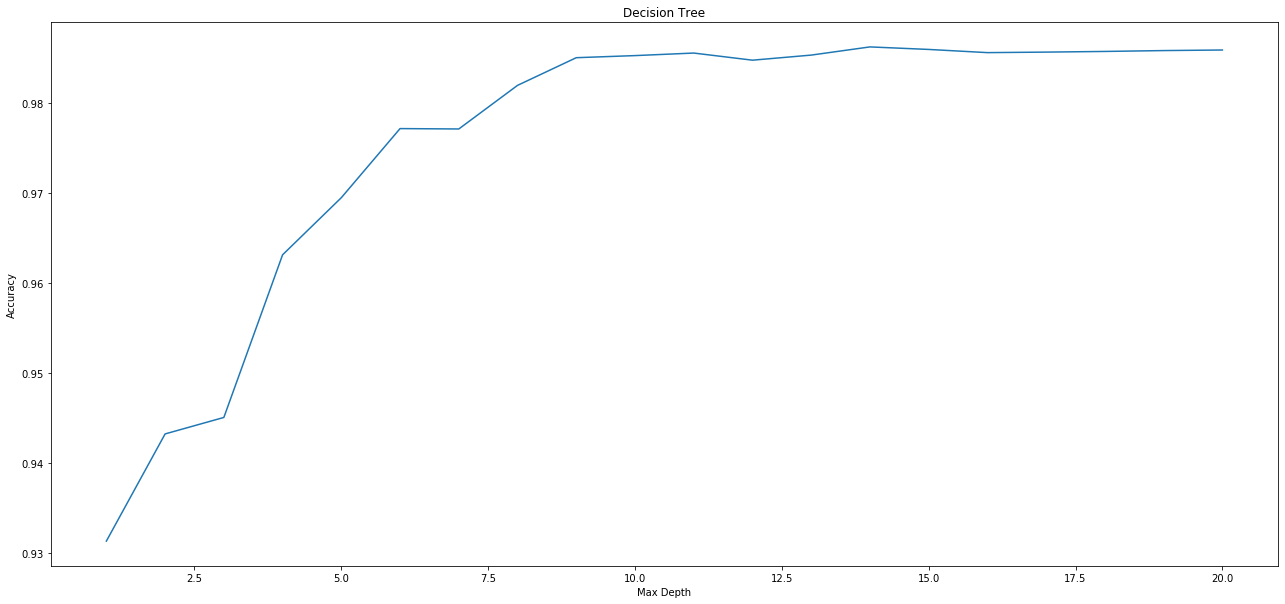

In [ ]:
fig = plt.figure(figsize = (22,10))

plt.plot(range(1,21), scores)
plt.title('Decision Tree')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
#informação 7.B

j=1
scoresRF = []
for j in range(1,21):

    rf7 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=j)
    modeloRF7 = rf7.fit(dfTreino5New)

    predicaoRF7 = modeloRF7.transform(dfTeste5New)
    predicaoRF7.select(func.col('prediction'), func.col('label'), func.col('id'))
    
    scoresRF.append(MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction')\
        .evaluate(predicaoRF7))
    
print(scoresRF)

[0.9692679763278491, 0.96903319482855, 0.974881571639471, 0.9760658276675594, 0.9738042164846625, 0.9799161256279221, 0.9758701435513972, 0.9766543971569203, 0.9791802241593048, 0.9746703182034008, 0.9777596215710516, 0.9762313711799253, 0.9764419976091661, 0.9788354533340005, 0.976053629248788, 0.9768191639527417, 0.9795120327521865, 0.9768835459640817, 0.9749315755697536, 0.9780248219202068]


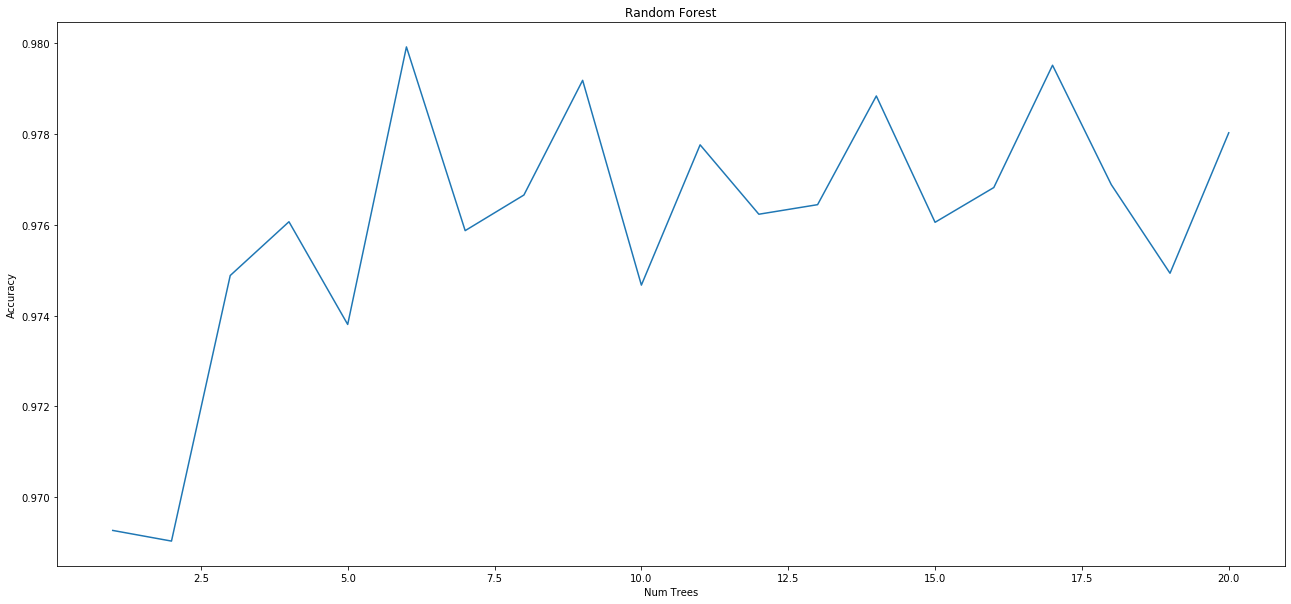

In [ ]:
fig = plt.figure(figsize = (22,10))

plt.plot(range(1,21), scoresRF)
plt.title('Random Forest')
plt.xlabel('Num Trees')
plt.ylabel('Accuracy')
plt.show()